# Resize images

Since all of our potential pretrained models require images in the size 224x244 pixels, we have to crop all images that are not in the correct ratio of 1:1 and then resize all images to 224x224 pixels.

In [52]:
import numpy as np
import os
import PIL
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

In [71]:
## try this
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.image import crop_and_resize

# Define the input folder containing subfolders of images
input_folder = '../data/images'

# Define the output folder for storing the cropped and resized images
output_folder = '../data/preprocessed_images/'

# Define the target size for cropping and resizing
target_size = (224, 224)

# Load and preprocess images
for root, dirs, files in os.walk(input_folder):
    for file_name in files:
        # Load the image file using Keras
        img_path = os.path.join(root, file_name)
        img = load_img(img_path)

        # Preprocess the image by converting to array and expanding dimensions
        img_array = img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        # Crop and resize the image using tf.image.crop_and_resize
        cropped_img_array = crop_and_resize(
            img_array,
            boxes=[[0, 0, 1, 1]],  # Crop the entire image
            box_indices=[0],
            crop_size=target_size
        )

        # Convert the cropped and resized image array back to an image object
        cropped_img = array_to_img(cropped_img_array[0])

        # Save the cropped and resized image to the output folder
        output_path = os.path.join(output_folder, file_name)
        cropped_img.save(output_path)

        print(f"Saved cropped and resized image: {output_path}")

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x293734400>

In [86]:
import PIL
from PIL import UnidentifiedImageError
import glob

imgs_ = glob.glob("../data/images/*/*.jpg")

for img in imgs_:
    try:
        img = PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(img)

In [82]:
import os

file_types = {}

def count_file_types(folder): 
    for root, dirs, files in os.walk(folder): 
        for file in files: # Get the file extension 
            file_extension = os.path.splitext(file)[1][1:].lower()
            file_types[file_extension] = file_types.get(file_extension, 0) + 1

folder_path = '../data/images'
count_file_types(folder_path)

for file_type, count in file_types.items(): print(f"{file_type}: {count}")

: 1
jpg: 93336
jpeg: 2522
png: 1


In [34]:
import sys
sys.path.append('../modeling') # adds the folder 'modeling' where our srips are stored to the path

from preprocessing import img_dataset_from_dir_and_split_train_val as set_split_train

README
- We use tensorflow-metal, on other os you need to use the gpu either with cuda for nvidia or rocm for amd


# --- Look inside cnn model ---

In [28]:
# import model
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('../models/efficient_unfrozen_12.h5')


In [71]:
# get class names

import os

def get_subfolders(subfolder_path):
    subfolders = []
    for foldername in os.listdir(subfolder_path):
        if os.path.isdir(os.path.join(subfolder_path, foldername)):
            subfolders.append(foldername)
    return subfolders

subfolder_path = '../data/train/'
class_names = get_subfolders(subfolder_path)

In [55]:
# python function to get model output; replace this function with your own model function.
import shap
import numpy as np
from PIL import Image


# input image

X = []
image1 = Image.open("../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG")
image1 = image1.resize((224, 224))
image1_array = np.array(image1)
X.append(image1_array)

image2 = Image.open("../data/train/citrus_greening/0a1c9371-1092-4228-b09e-a4d0647e5316___CREC_HLB 4844.JPG")
image2 = image2.resize((224, 224))
image2_array = np.array(image2)
X.append(image2_array)

X = np.array(X)

X.shape

(2, 224, 224, 3)

In [49]:
from PIL import Image

def resize_image(input_image_path, output_image_path):
    original_image = Image.open(input_image_path)
    width, height = original_image.size
    resize_image = original_image.resize((224, 224))
    resize_image.save(output_image_path)

# Example usage
input_path = "path/to/input/image.jpg"
output_path = "path/to/output/resized_image.jpg"
resize_image(input_path, output_path)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/input/image.jpg'

In [42]:
# reshape imgage to fit output layer of model
new_shape = (224 * 224 * 3)
X = np.reshape(X,new_shape)

ValueError: cannot reshape array of size 196608 into shape (150528,)

In [56]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[0], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

DimensionError: The length of the image to be masked must match the shape given in the ImageMasker constructor: 224 * 3 != 224 * 224 * 3

In [57]:
print("Image shape:", X.shape)
print("Model input shape:", model.input_shape)

Image shape: (2, 224, 224, 3)
Model input shape: (None, 224, 224, 3)


TypeError: Invalid shape (2, 224, 224, 3) for image data

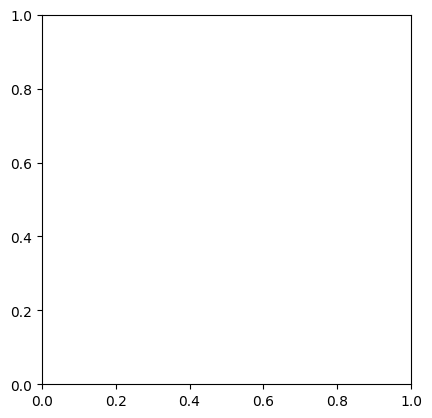

In [58]:
from matplotlib import pyplot as plt
plt.imshow(X)
plt.show()

In [23]:
# output with shap values
shap.image_plot(shap_values)


NameError: name 'shap_values' is not defined

In [68]:
import tensorflow as tf
from tensorflow import keras

def extract_layer_from_model(model_file_path, layer_name):
    # Load the saved model
    model = keras.models.load_model(model_file_path)
    
    # Extract the layer by its name
    extracted_layer = model.get_layer(layer_name)
    
    return extracted_layer

X = extract_layer_from_model("../models/efficient_unfrozen_12.h5", "pred")

In [62]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0

In [4]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[0], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

NameError: name 'X' is not defined

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import shap

# Load pre-trained model
model = keras.models.load_model('../models/efficient_unfrozen_12.h5')

# Load and preprocess input image
img_path = '../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG'
img = Image.open(img_path).resize((224, 224))
x = np.array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get model predictions for input image
preds = model.predict(x)
top_preds = decode_predictions(preds, top=5)[0]

# Initialize SHAP explainer with VGG16 model and desired background dataset (e.g., ImageNet)
explainer = shap.Explainer(model, preprocess_input, output_names=top_preds[0][1])

# Calculate SHAP values for the input image to determine feature importance
shap_values = explainer(x)

# Create heatmap using the SHAP values
heatmap = shap.image_plot(shap_values[0], x[0], show=False)

# Display the input image with the heatmap overlay
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Input Image')

axs[1].imshow(img)
axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
axs[1].axis('off')
axs[1].set_title('Heatmap Overlay')

# Show the plot
plt.tight_layout()
plt.show()

2024-02-15 09:44:15.979007: W tensorflow/c/c_api.cc:305] Operation '{name:'block6a_project_bn_2/moving_variance/Assign' id:17417 op device:{requested: '', assigned: ''} def:{{{node block6a_project_bn_2/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block6a_project_bn_2/moving_variance, block6a_project_bn_2/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-02-15 09:44:18.050234: W tensorflow/c/c_api.cc:305] Operation '{name:'learning_rate_2/Assign' id:20349 op device:{requested: '', assigned: ''} def:{{{node learning_rate_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](learning_rate_2, learning_rate_2/Initializer/initial_value)}}' was changed by setting attr

RuntimeError: Attempted to aggregate unsupported object Tensor("EfficientNet/pred/Softmax:0", shape=(1, 39), dtype=float32).

In [2]:
import tensorflow as tf
import numpy as np
import shap
import keras
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt

from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
tf.config.run_functions_eagerly(True)

import keras.backend as K




# Define the preprocessing function for the EfficientNetB0 model
def preprocess_input(x):
    return efn.preprocess_input(x)

# Load the pre-trained EfficientNetB0 model
model = keras.models.load_model('../models/efficient_unfrozen_12.h5')

# Load an example image for testing
img = plt.imread('../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG')
img = tf.image.resize(img, (224, 224))  # Resize the image to fit the model's input size
#img = img.numpy()
img = K.eval(img)

# Preprocess the image
img_processed = preprocess_input(img[np.newaxis])

# Create an explainer object using the pre-trained model's predict function
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)
explainer = shap.DeepExplainer(model, img_processed)

# Generate SHAP values for the image
shap_values = explainer.shap_values(img_processed)

# Plot the heatmaps on the original image
shap_image = shap.image_plot(shap_values, img, show=False)
plt.imshow(shap_image)
plt.axis('off')
plt.show()


2024-02-15 09:38:48.151715: W tensorflow/c/c_api.cc:305] Operation '{name:'block6d_expand_bn_1/gamma/Assign' id:11326 op device:{requested: '', assigned: ''} def:{{{node block6d_expand_bn_1/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block6d_expand_bn_1/gamma, block6d_expand_bn_1/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-02-15 09:38:49.710556: W tensorflow/c/c_api.cc:305] Operation '{name:'beta_2_1/Assign' id:13495 op device:{requested: '', assigned: ''} def:{{{node beta_2_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta_2_1, beta_2_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, 

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [5]:
import json
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import efficientnet.tfkeras as efn
from PIL import Image
import shap

# load pre-trained model
model = keras.models.load_model('../models/efficient_unfrozen_12.h5')


def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)


# X, y = shap.datasets.imagenet50()

# get example image
data_dir = '../data/train/'
test_images = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=42,
    image_size=(224,224))



'''
# Load an example image for testing
X = Image.open('../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG')
X = X.resize((224, 224))  # Resize the image to fit the model's input size
X = [np.array(X)]
'''

# get class names
import os

def get_subfolders(subfolder_path):
    subfolders = []
    for foldername in os.listdir(subfolder_path):
        if os.path.isdir(os.path.join(subfolder_path, foldername)):
            subfolders.append(foldername)
    return subfolders

subfolder_path = '../data/train/'
class_names = get_subfolders(subfolder_path)

# define a masker that is used to mask out partitions of the input image
masker = shap.maskers.Image("inpaint_telea", test_images[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    test_images[0], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1]
)
shap.image_plot(shap_values)

Found 76687 files belonging to 39 classes.


TypeError: '_PrefetchDataset' object is not subscriptable

2024-02-19 19:22:00.074639: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-19 19:22:00.074664: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-19 19:22:00.074667: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-19 19:22:00.075041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 19:22:00.075389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(-0.5, 223.5, 223.5, -0.5)

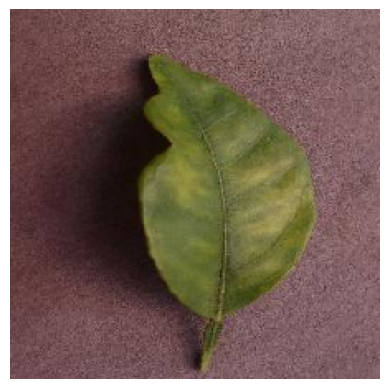

In [2]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap
import warnings

# load model
model = keras.models.load_model('../models/efficient_unfrozen_12.h5')

# load image
file = '../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG'
img = image.load_img(file, target_size=(224,224))
img_orig = image.img_to_array(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

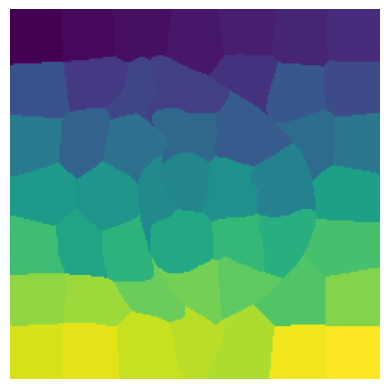

In [3]:
# Slice the image to make it faster to process

import numpy as np

# Convert the Image object to a numpy array
img_array = np.array(img)

# Apply SLIC algorithm on the numpy array
segments_slic = slic(img_array, n_segments=50, compactness=30, sigma=3)

# Display the result
plt.imshow(segments_slic)
plt.axis('off')

In [4]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [5]:
import os

def get_subfolders(subfolder_path):
    subfolders = []
    for foldername in os.listdir(subfolder_path):
        if os.path.isdir(os.path.join(subfolder_path, foldername)):
            subfolders.append(foldername)
    return subfolders

subfolder_path = '../data/train/'
feature_names = get_subfolders(subfolder_path)

In [6]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

2024-02-19 19:23:42.188770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 11s 262ms/step


In [15]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

1/1 [==============================] - 0s 311ms/step


TypeError: list indices must be integers or slices, not str

In [12]:
shap.image_plot(shap_values[0])



AttributeError: 'NoneType' object has no attribute 'shape'

In [14]:
shap_values[0].shape


(1, 50)

In [14]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

1/1 [==============================] - 0s 146ms/step


TypeError: list indices must be integers or slices, not str

TypeError: list indices must be integers or slices, not str

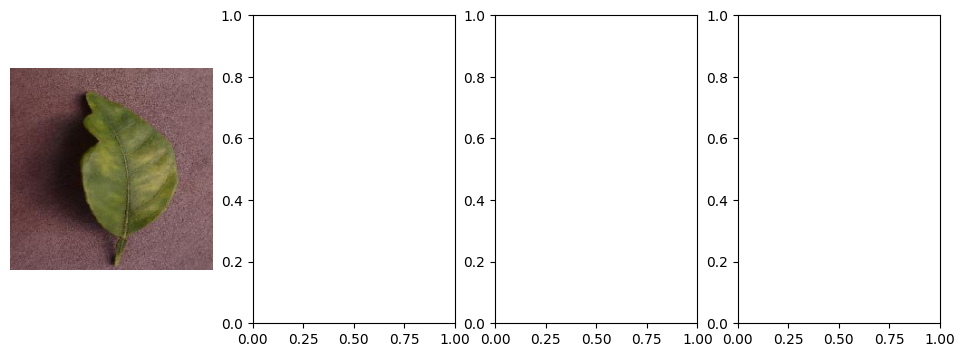

In [15]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)

cb.outline.set_visible(False)

plt.show()

In [16]:
import os
import cv2
import numpy as np

def create_array_from_directory(directory):
    # Get the list of image file paths in the directory
    file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")]

    # Load the images and store their pixel values in a list
    pixel_values = []
    for file_path in file_paths:
        image = cv2.imread(file_path)
        pixel_values.append(image)

    # Convert the list of pixel values to a Numpy array
    pixel_array = np.array(pixel_values)

    return pixel_array

# Example usage
directory_path = "../data/test/citrus_greening/"
X_test = create_array_from_directory(directory_path)
print(X_test.shape)  # (num_images, height, width, num_channels)

(0,)


In [17]:
for images, labels in model.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

AttributeError: 'Functional' object has no attribute 'take'

In [18]:
import shap

# define X_test (np array with pixel values)
#X_test = 

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("blur(128,128)", X_test[0].shape)
#an example for another masker type "inpaint_telea"

# get class names
import os

def get_subfolders(subfolder_path):
    subfolders = []
    for foldername in os.listdir(subfolder_path):
        if os.path.isdir(os.path.join(subfolder_path, foldername)):
            subfolders.append(foldername)
    return subfolders

subfolder_path = '../data/train/'
class_names = get_subfolders(subfolder_path)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker, output_names=class_names)

#number of classes shown in the shap plot grid (starting with the highest probability)
shown_classes = 2

# here we explain two images using 50 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer_blur(
    X_test[1:3], max_evals=50, batch_size=50, outputs=shap.Explanation.argsort.flip[:shown_classes]
)
shap.image_plot(shap_values)

IndexError: index 0 is out of bounds for axis 0 with size 0

# (https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html)

In [18]:
# load model
model = keras.models.load_model('../models/efficient_unfrozen_12.h5')


In [65]:
def get_subfolders(subfolder_path):
    subfolders = []
    for foldername in os.listdir(subfolder_path):
        if os.path.isdir(os.path.join(subfolder_path, foldername)):
            subfolders.append(foldername)
    return subfolders

subfolder_path = '../data/train/'
class_names = sorted(get_subfolders(subfolder_path))


(-0.5, 223.5, 223.5, -0.5)

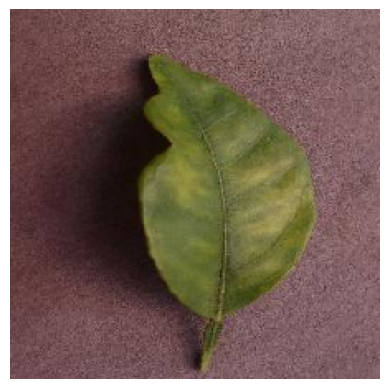

In [36]:
# load image
file = '../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG'
img = image.load_img(file, target_size=(224,224))
img_orig = image.img_to_array(img)
plt.imshow(img)
plt.axis('off')

In [37]:
img_orig.shape


(224, 224, 3)

In [38]:
img_orig


array([[[117.,  78.,  79.],
        [116.,  77.,  78.],
        [111.,  72.,  73.],
        ...,
        [134., 102., 105.],
        [138., 106., 109.],
        [143., 111., 114.]],

       [[105.,  66.,  67.],
        [108.,  69.,  70.],
        [106.,  67.,  68.],
        ...,
        [136., 104., 107.],
        [132., 100., 103.],
        [133., 101., 104.]],

       [[ 93.,  54.,  55.],
        [ 99.,  60.,  61.],
        [101.,  62.,  63.],
        ...,
        [133., 101., 104.],
        [136., 104., 107.],
        [145., 113., 116.]],

       ...,

       [[112.,  77.,  83.],
        [125.,  90.,  96.],
        [131.,  96., 102.],
        ...,
        [125.,  94.,  99.],
        [133., 102., 107.],
        [130.,  99., 104.]],

       [[121.,  86.,  92.],
        [129.,  94., 100.],
        [127.,  92.,  98.],
        ...,
        [129.,  98., 103.],
        [135., 104., 109.],
        [126.,  95., 100.]],

       [[ 95.,  60.,  66.],
        [111.,  76.,  82.],
        [119.,  

In [39]:
img_orig = np.expand_dims(img_orig, axis=0)
img_orig.shape


(1, 224, 224, 3)

In [40]:
img_orig[0]


array([[[117.,  78.,  79.],
        [116.,  77.,  78.],
        [111.,  72.,  73.],
        ...,
        [134., 102., 105.],
        [138., 106., 109.],
        [143., 111., 114.]],

       [[105.,  66.,  67.],
        [108.,  69.,  70.],
        [106.,  67.,  68.],
        ...,
        [136., 104., 107.],
        [132., 100., 103.],
        [133., 101., 104.]],

       [[ 93.,  54.,  55.],
        [ 99.,  60.,  61.],
        [101.,  62.,  63.],
        ...,
        [133., 101., 104.],
        [136., 104., 107.],
        [145., 113., 116.]],

       ...,

       [[112.,  77.,  83.],
        [125.,  90.,  96.],
        [131.,  96., 102.],
        ...,
        [125.,  94.,  99.],
        [133., 102., 107.],
        [130.,  99., 104.]],

       [[121.,  86.,  92.],
        [129.,  94., 100.],
        [127.,  92.,  98.],
        ...,
        [129.,  98., 103.],
        [135., 104., 109.],
        [126.,  95., 100.]],

       [[ 95.,  60.,  66.],
        [111.,  76.,  82.],
        [119.,  

In [67]:
p = model.predict(img_orig)

1/1 [==============================] - 0s 136ms/step


In [70]:
# Assuming p contains the predicted probabilities returned by the model
# and class_names contains the list of class labels

# Map each predicted probability vector to a dictionary of {label: score}
predictions_with_labels = [{class_names[i]: score for i, score in enumerate(prediction)} for prediction in p]

print("Predictions with labels and scores:")
for prediction in predictions_with_labels:
    print(prediction)


Predictions with labels and scores:
{'alternaria_leaf_spot': 7.5009475e-06, 'bacterial_blight': 3.2508124e-06, 'bacterial_spot': 0.00021908442, 'bacterial_wilt': 1.4589855e-06, 'black_measles': 4.4508383e-07, 'black_rot': 1.8202869e-05, 'blast': 5.0839985e-06, 'brown_spot': 3.9173447e-06, 'brown_streak_disease': 5.0178505e-07, 'citrus_greening': 0.9955721, 'common_rust': 1.4893982e-06, 'early_blight': 2.2645513e-06, 'gray_leaf_spot': 1.5837757e-06, 'gray_spot': 7.374803e-06, 'green_mottle': 2.599017e-07, 'healthy': 4.001188e-06, 'isariopsis_leaf_spot': 1.644962e-06, 'late_blight': 7.907502e-05, 'leaf_blight': 4.9805016e-07, 'leaf_curl': 3.4345754e-05, 'leaf_mold': 0.0018193232, 'leaf_scorch': 5.2384706e-07, 'mosaic': 1.0207647e-06, 'mosaic_disease': 1.6138479e-07, 'mosaic_virus': 0.00021520254, 'nematode': 5.971785e-06, 'northern_leaf_blight': 6.329293e-06, 'pests': 3.347643e-07, 'phytophthora': 2.6916365e-07, 'powdery_mildew': 0.00015028974, 'red_rot': 4.877991e-06, 'rust': 2.1652075e

In [ ]:
def predict(filename:str) -> list:
    """Return prediction from imagefile"""
    img = image.load_img(filename, target_size=(224,224))
    img = image.img_to_array(img)
    p = model.predict(img)
    predictions_with_labels = [{class_names[i]: score for i, score in enumerate(prediction)} for prediction in p]
    return predictions_with_labels

    
file = '../data/train/citrus_greening/0a0e1e0f-e0d2-4a9b-9265-ec636592d0b2___CREC_HLB 7565.JPG'